# Will it rain tomorrow in Australia?

The objective of this, is to find the best model that will predict if it will rain tomorrow in Australia. The data-set is from Kaggle, but we will load it from a github repositiry, as Kaggle downlaod service is not reliable.

We will start by importing all the libaries we require.

In [227]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

Loading the data into a pandas Data Frame.

In [228]:
df = pd.read_csv("https://raw.githubusercontent.com/medzz123/rain-data/main/weatherAUS.csv",  na_values=['NA', '?'])

## Resuffle Data?

Now lets check the summary of the data. This should give us the shape of the data, and its feature columns. 

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [230]:
df.count().sort_values()

Sunshine          75625
Evaporation       82670
Cloud3pm          86102
Cloud9am          89572
Pressure9am      130395
Pressure3pm      130432
WindDir9am       134894
WindGustDir      135134
WindGustSpeed    135197
Humidity3pm      140953
WindDir3pm       141232
Temp3pm          141851
RainTomorrow     142193
RainToday        142199
Rainfall         142199
WindSpeed3pm     142398
Humidity9am      142806
Temp9am          143693
WindSpeed9am     143693
MinTemp          143975
MaxTemp          144199
Location         145460
Date             145460
dtype: int64

We can observe that there is a total of 145460 entries with 23 columns. There are lot of columns which contains null values. 

Our target is `RainTomorrow`. As this column contains null values, we can drop those entries, as we won't be able test the accuracy of our model of those entries. 

We will also drop Location, as it the objective is to find out if it will rain tomorrow in Australia, not in a specific location. 

In [231]:
target = 'RainTomorrow'

df = df.drop(columns=['Location'],axis=1)

df = df[df[target].notna()]

df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [232]:
df.shape

(142193, 22)

We can observe that arround 3 thousand entries have dropped. Now we need to observe the type of our target. 

In [233]:
df[target].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

We can see that `RainTomorrow` can either be `Yes` or `No` which translates to Classification problem. Lets check the propoptions between these two. 

In [234]:
df[target].value_counts()/len(df)

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

We can observe that in Australia it rains only 22% of the time. Lets plot this a chart.

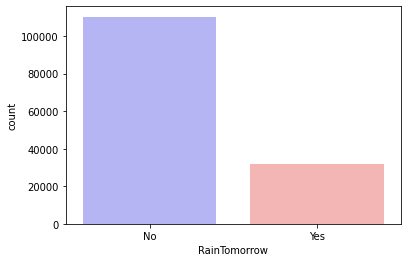

In [235]:
sns.countplot(x=target, data=df, palette="bwr")
plt.show()

This also shows that our dataset is imbalanced. This means that whichever model we use, we will get almost perfect accuracy. To mitigate that, we will oversample the minority values. This is done by generating new samples.

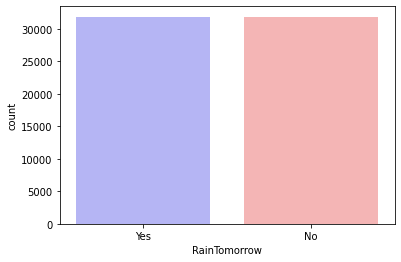

In [236]:
yesRain = df[df.RainTomorrow == "No"]
noRain = df[df.RainTomorrow == "Yes"]

yesOversampled = resample(yesRain, replace = True, n_samples=len(noRain), random_state=123)
df = pd.concat([noRain, yesOversampled])

sns.countplot(x='RainTomorrow', data=df, palette="bwr")
plt.show()

## Explore Values

In [237]:
categorical = [name for name in df.columns if df[name].dtype=='O']

df[categorical].head()

,Date,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
8,2008-12-09,NNW,SE,NW,No,Yes
10,2008-12-11,N,SSE,ESE,No,Yes
11,2008-12-12,NNE,NE,ENE,Yes,Yes
12,2008-12-13,W,NNW,NNW,Yes,Yes
16,2008-12-17,ENE,SSW,E,No,Yes


Look for missing values of the categorical values

In [238]:
df[categorical].isnull().sum()

Date               0
WindGustDir     4434
WindDir9am      4217
WindDir3pm      1835
RainToday        867
RainTomorrow       0
dtype: int64

Lets replace all missing ones with the most common one.

In [239]:
contains_null = [col for col in categorical if df[col].isnull().sum()!=0]

for col in contains_null:
  most_common = df[col].mode()
  df[col].fillna(most_common[0], inplace=True)

In [240]:
df[categorical].isnull().sum()

Date            0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [241]:
numerical = [name for name in df.columns if df[name].dtype!='O']

df[numerical].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
8,9.7,31.9,0.0,NaN,NaN,80.0,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2
10,13.4,30.4,0.0,NaN,NaN,30.0,17.0,6.0,48.0,22.0,1011.8,1008.7,NaN,NaN,20.4,28.8
11,15.9,21.7,2.2,NaN,NaN,31.0,15.0,13.0,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0
12,15.9,18.6,15.6,NaN,NaN,61.0,28.0,28.0,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8
16,14.1,20.9,0.0,NaN,NaN,22.0,11.0,9.0,69.0,82.0,1012.2,1010.4,8.0,1.0,17.2,18.1


Look for missing values in the numerical data

In [242]:
df[numerical].isnull().sum()

MinTemp            307
MaxTemp            143
Rainfall           867
Evaporation      27627
Sunshine         30374
WindGustSpeed     4403
WindSpeed9am       605
WindSpeed3pm      1230
Humidity9am        894
Humidity3pm       1755
Pressure9am       6297
Pressure3pm       6284
Cloud9am         23530
Cloud3pm         24822
Temp9am            476
Temp3pm           1332
dtype: int64

In [243]:
df.isnull().sum()

Date                 0
MinTemp            307
MaxTemp            143
Rainfall           867
Evaporation      27627
Sunshine         30374
WindGustDir          0
WindGustSpeed     4403
WindDir9am           0
WindDir3pm           0
WindSpeed9am       605
WindSpeed3pm      1230
Humidity9am        894
Humidity3pm       1755
Pressure9am       6297
Pressure3pm       6284
Cloud9am         23530
Cloud3pm         24822
Temp9am            476
Temp3pm           1332
RainToday            0
RainTomorrow         0
dtype: int64

Lets check the info of the numerical values

In [244]:
df[numerical].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,63447.000000,63611.000000,62887.000000,36127.000000,33380.000000,59351.000000,63149.000000,62524.000000,62860.000000,61999.000000,57457.000000,57470.000000,40224.000000,38932.000000,63278.000000,62422.000000
mean,12.535220,22.454286,3.674941,5.153522,6.491836,42.134454,14.551283,19.177420,72.102195,57.673301,1016.474001,1014.198163,5.056906,5.207875,16.858518,20.779054
std,6.391187,7.125528,10.988083,4.039621,3.934987,14.697019,9.202797,9.167757,18.571167,21.766891,7.328239,7.269191,2.775844,2.617885,6.453520,6.946309
min,-8.200000,-4.100000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.000000,-4.400000
25%,7.900000,17.200000,0.000000,2.400000,3.200000,31.000000,7.000000,13.000000,60.000000,43.000000,1011.700000,1009.300000,2.000000,3.000000,12.100000,15.700000
50%,12.200000,21.700000,0.000000,4.400000,6.800000,41.000000,13.000000,19.000000,74.000000,58.000000,1016.400000,1014.100000,6.000000,6.000000,16.500000,20.100000
75%,17.200000,27.400000,2.200000,7.000000,9.900000,50.000000,20.000000,24.000000,87.000000,73.000000,1021.400000,1019.100000,7.000000,7.000000,21.400000,25.500000
max,30.700000,47.300000,371.000000,145.000000,14.500000,135.000000,87.000000,87.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,39.400000,46.700000


Lets check if there are any outliers in numerical values by drawing some box plots.

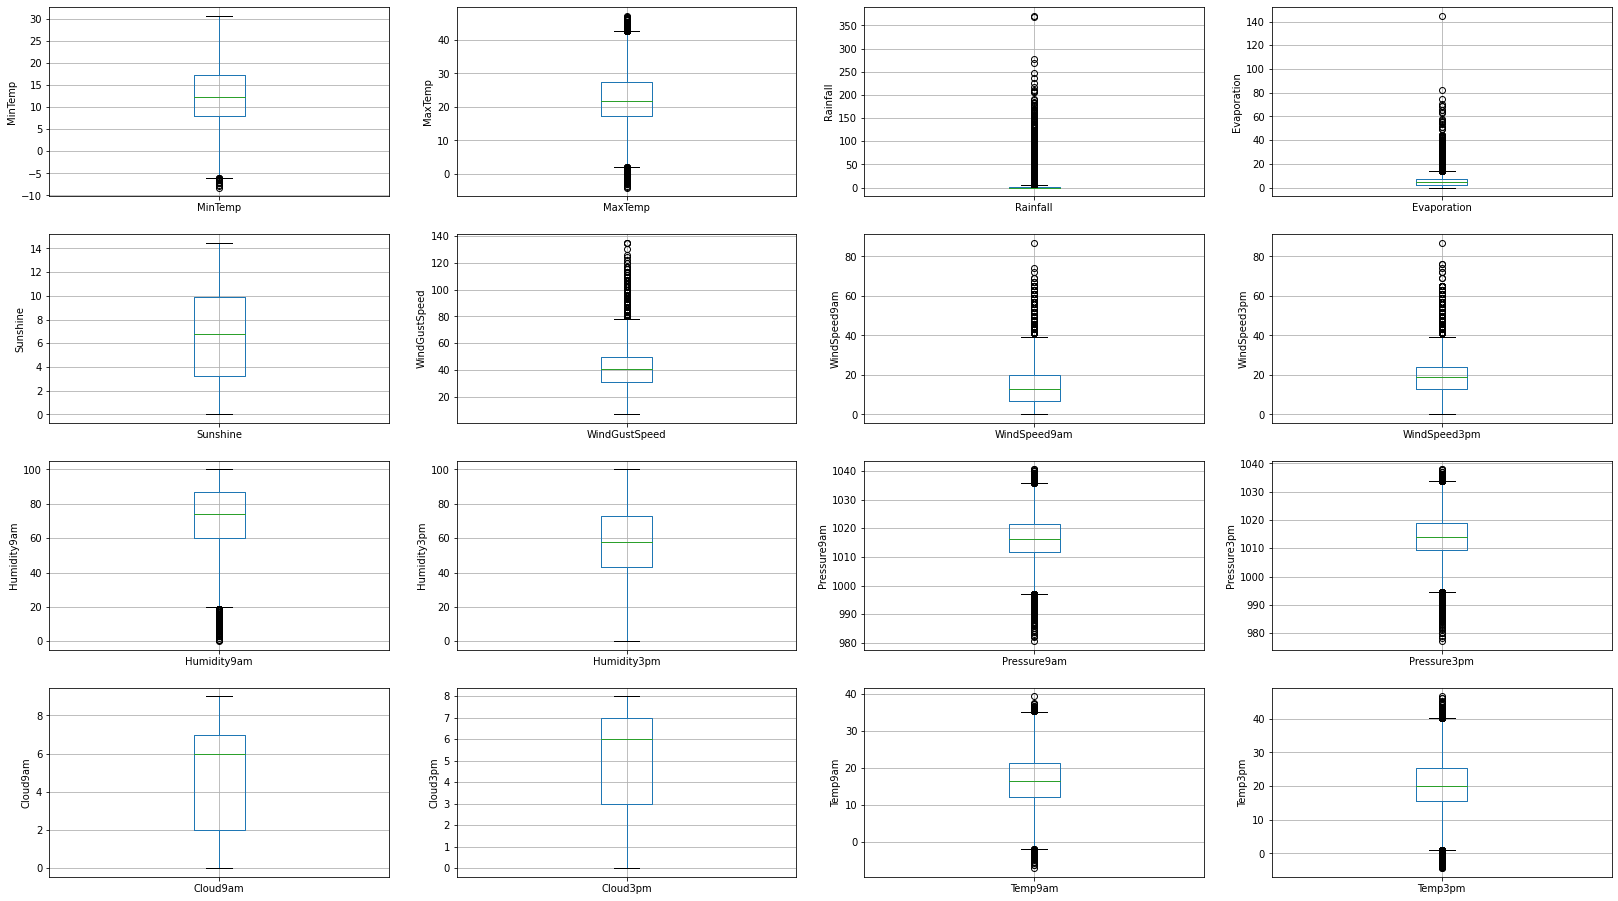

In [245]:
plt.figure(figsize=(28,16))

for index, value in enumerate(numerical):
  n = index + 1
  plt.subplot(4, 4, n)
  fig = df.boxplot(column=value)
  fig.set_ylabel(value)

We can observe from these that RainFall, WindSpeed 9am, WindSpeed 3pm and Evaporation might have outliers. Letse check these more in detail.

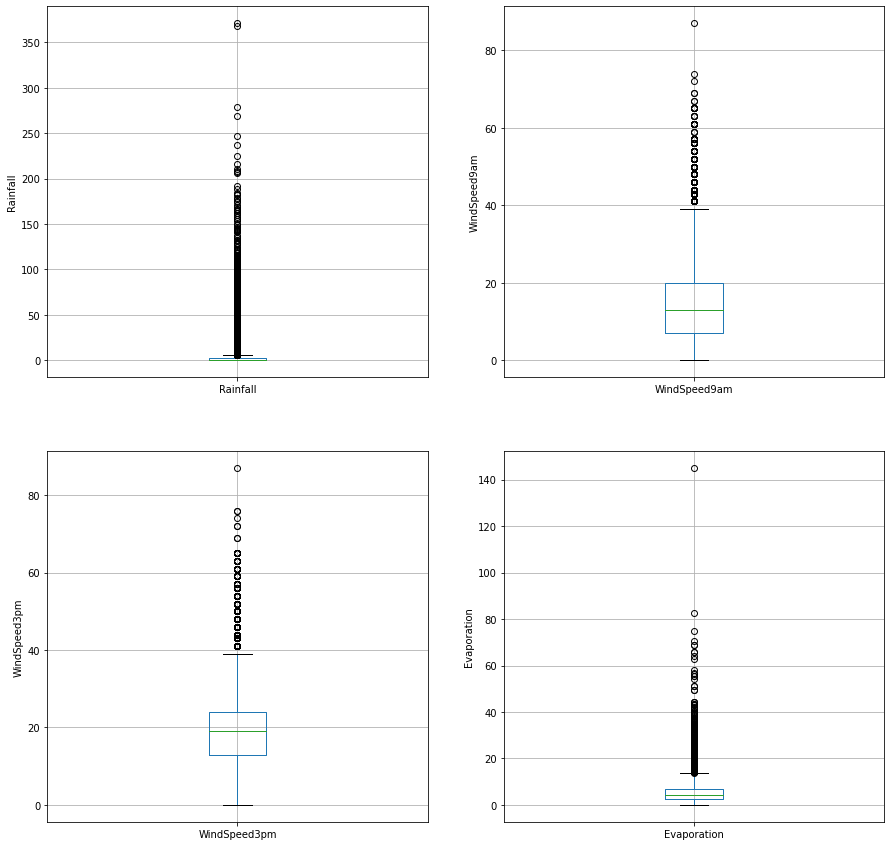

In [246]:
outliers = ['Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Evaporation']

plt.figure(figsize=(15,15))

for index, value in enumerate(outliers):
  n = index + 1
  plt.subplot(2, 2, n)
  fig = df.boxplot(column=value)
  fig.set_ylabel(value)

Finding the upper and lower bounds of the outliers using IQR

In [247]:
# Rainfall find outlier using IQR and replace

IQR = df.Rainfall.quantile(0.75) - df.Rainfall.quantile(0.25)
Upper_boundery = df.Rainfall.quantile(0.75) + (IQR * 3)

median = df['Rainfall'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["Rainfall"] = np.where(df["Rainfall"] >Upper_boundery, median,df['Rainfall'])

Upper boundary is: 8.8 and Median is 0.0


In [248]:
# Windspeed 9 am
IQR = df.WindSpeed9am.quantile(0.75) - df.WindSpeed9am.quantile(0.25)
Upper_boundery = df.WindSpeed9am.quantile(0.75) + (IQR * 3)

median = df['WindSpeed9am'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["WindSpeed9am"] = np.where(df["WindSpeed9am"] >Upper_boundery, median,df['WindSpeed9am'])

Upper boundary is: 59.0 and Median is 13.0


In [249]:
# Windspeed 3 pm
IQR = df.WindSpeed3pm.quantile(0.75) - df.WindSpeed3pm.quantile(0.25)
Upper_boundery = df.WindSpeed3pm.quantile(0.75) + (IQR * 3)

median = df['WindSpeed3pm'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["WindSpeed3pm"] = np.where(df["WindSpeed3pm"] >Upper_boundery, median,df['WindSpeed3pm'])

Upper boundary is: 57.0 and Median is 19.0


In [250]:
# Evaporation
IQR = df.Evaporation.quantile(0.75) - df.Evaporation.quantile(0.25)
Upper_boundery = df.Evaporation.quantile(0.75) + (IQR * 3)

median = df['Evaporation'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["Evaporation"] = np.where(df["Evaporation"] >Upper_boundery, median,df['Evaporation'])

Upper boundary is: 20.799999999999997 and Median is 4.4


Lets check the box plots after fixing the outliers

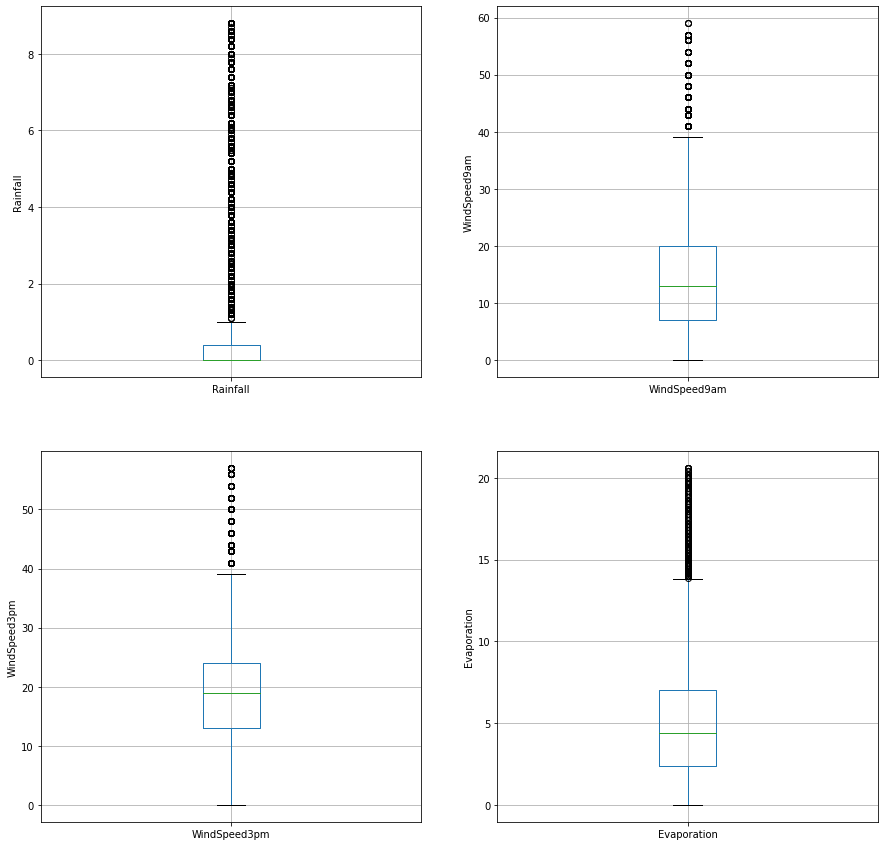

In [251]:
plt.figure(figsize=(15,15))

for index, value in enumerate(outliers):
  n = index + 1
  plt.subplot(2, 2, n)
  fig = df.boxplot(column=value)
  fig.set_ylabel(value)

Looks better now.

Now lets replaces all the NA numerical values with the median one.

In [252]:
for col in numerical:
  col_median = df[col].median()
  df[col].fillna(col_median, inplace=True)

df[numerical].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

Now theres no null values anymore. Lastly encode categorical values




In [253]:
df = df.apply(LabelEncoder().fit_transform)

df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
8,300,169,346,0,44,68,6,39,9,7,4,15,42,9,223,194,6,6,231,341,0,1
10,302,206,331,0,44,68,3,12,10,2,9,3,48,22,252,245,6,6,252,327,0,1
11,303,231,244,22,44,68,5,13,4,1,8,7,89,91,239,200,8,8,207,209,1,1
12,304,231,213,0,44,68,13,29,6,6,15,15,76,93,77,88,8,8,222,197,1,1
16,308,213,236,0,44,68,1,8,11,0,6,5,69,82,256,262,8,1,220,220,0,1


Reshuffle the data before spliting. We notcied that there are duplicate entries in the data. We deicded to drop them, as reshuffling is not possible with them. 

In [254]:
df.drop_duplicates(keep = False, inplace = True)

df = df.reindex(np.random.permutation(df.index))

Split data into train and test set

In [255]:
y = df[target]
X = df.drop([target], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((44852, 21), (11214, 21))

### Function to plot confusion matrices

In [256]:
def plot_confusion_matrix(cm):
  cm_matrix = pd.DataFrame(data=cm, columns=['TP:1', 'TN:0'], 
                                 index=['FP:1', 'FN:0'])
  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)

  print('\nTrue Positives = ', cm[0,0])
  print('\nTrue Negatives = ', cm[1,1])
  print('\nFalse Positives = ', cm[0,1])
  print('\nFalse Negatives = ', cm[1,0])

# Decision Tree Classifier

In [257]:
tree = DecisionTreeClassifier(criterion = 'entropy', splitter='random', random_state=2, max_depth=10).fit(X_train,y_train)

y_pred_test = tree.predict(X_test)

dtc_score = accuracy_score(y_test, y_pred_test)

print(f'Model accuracy score: {dtc_score}')

Model accuracy score: 0.759318708756911


Compare train and test set accuracy score

In [258]:
y_pred_train = tree.predict(X_train)

dtc_score2 = accuracy_score(y_train, y_pred_train)

print(f'Model accuracy score: {dtc_score2}')

Model accuracy score: 0.7801881744403817


Plotting confusion matrices


True Positives =  3512

True Negatives =  5003

False Positives =  1285

False Negatives =  1414


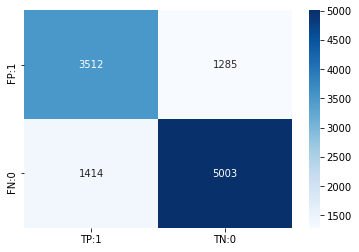

In [259]:
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)

# Logistic Regression Model

In [260]:
logreg = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

y_pred_test = logreg.predict(X_test)

lr_score = accuracy_score(y_test, y_pred_test)

print(f'Model accuracy score: {lr_score}')

Model accuracy score: 0.7830390583199572


Compare againts test set

In [261]:
y_pred_train = logreg.predict(X_train)

lr_score2 = accuracy_score(y_train, y_pred_train)

print(f'Model accuracy score: {lr_score2}')

Model accuracy score: 0.7808570409346295



True Positives =  3515

True Negatives =  5266

False Positives =  1282

False Negatives =  1151


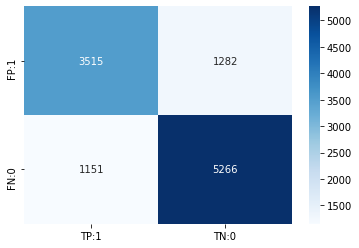

In [262]:
cm = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm)

# Neural Network Model

In [263]:
nn_model = MLPClassifier(random_state = 0, max_iter=500, learning_rate='constant').fit(X_train, y_train)

nn_score = nn_model.score(X_test, y_test)

y_pred_test = nn_model.predict(X_test)

print(f'Model accuracy score: {nn_score}')

Model accuracy score: 0.7023363652577136


In [264]:
y_pred_train = nn_model.predict(X_train)

nn_score2 = accuracy_score(y_train, y_pred_train)

print(f'Model accuracy score: {nn_score2}')

Model accuracy score: 0.7060331757781146



True Positives =  1726

True Negatives =  6150

False Positives =  3071

False Negatives =  267


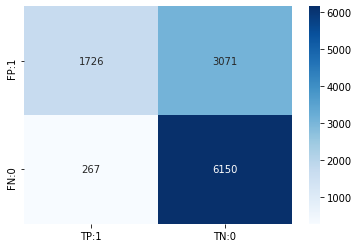

In [265]:
cm = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm)

# Hyperparameter Optimization using GridSearch

GridSearch for Logistic Regression model

In [266]:
from sklearn.model_selection import GridSearchCV

params = [{'penalty':['l1','l2']}, {'C':[1, 10, 100, 1000]}]

gs_lr = GridSearchCV(estimator = logreg,  
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [267]:
print('GridSearch CV best score for LR model: {:.4f}\n\n'.format(gs_lr.best_score_))

print('Parameters that give the best results :','\n\n', (gs_lr.best_params_))

print('\n\nEstimator that was chosen by the search :','\n\n', (gs_lr.best_estimator_))

GridSearch CV best score for LR model: 0.7826


Parameters that give the best results : 

 {'penalty': 'l1'}


Estimator that was chosen by the search : 

 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


GridSearch for Decision Tree Classifier model

In [268]:
depth = np.arange(1,30)
leaves = [1,2,4,5,10,20,30,40,80,100]
param_grid =[{'max_depth':depth,
             'min_samples_leaf':leaves}]
gs_tree = GridSearchCV(estimator = tree,param_grid = param_grid,cv=10)
gs_tree.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy', max_depth=10,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=2,
                                              splitter='random'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,

In [269]:
print('GridSearch CV best score for DTC model: {:.4f}\n\n'.format(gs_tree.best_score_))

print('Parameters that give the best results :','\n\n', (gs_tree.best_params_))

print('\n\nEstimator that was chosen by the search :','\n\n', (gs_tree.best_estimator_))

GridSearch CV best score for DTC model: 0.7684


Parameters that give the best results : 

 {'max_depth': 15, 'min_samples_leaf': 40}


Estimator that was chosen by the search : 

 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2, splitter='random')


GridSearch for NN model

In [270]:
param_grid = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
nn_gs = GridSearchCV(estimator=nn_model, param_grid=param_grid, n_jobs=-1, cv=3)
nn_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                

In [271]:
print('GridSearch CV best score for NN model: {:.4f}\n\n'.format(nn_gs.best_score_))

print('Parameters that give the best results :','\n\n', (nn_gs.best_params_))

print('\n\nEstimator that was chosen by the search :','\n\n', (nn_gs.best_estimator_))

GridSearch CV best score for NN model: 0.7090


Parameters that give the best results : 

 {'alpha': 1e-05, 'hidden_layer_sizes': 5, 'max_iter': 1500, 'random_state': 2, 'solver': 'lbfgs'}


Estimator that was chosen by the search : 

 MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [283]:
scores = [[dtc_score, gs_tree.best_score_], [lr_score,gs_lr.best_score_], [nn_score,nn_gs.best_score_]]

scores

[[0.759318708756911, 0.7684384665584145],
 [0.7830390583199572, 0.7825959778486035],
 [0.7023363652577136, 0.7090446003209147]]

ValueError: ignored

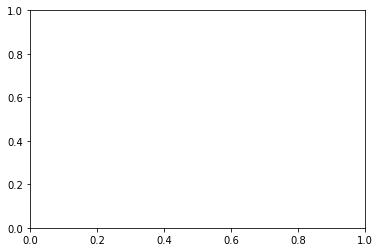

In [287]:
plt.bar([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],scores)
plt.show()

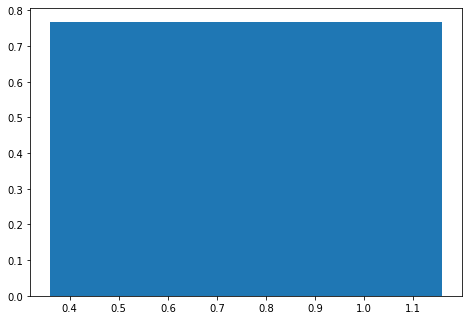

In [275]:
fig = plt.figure()
models = [dtc_score, lr_score, nn_score]
#optimised_models = [gs_tree.best_score_, lr_gs.best_score_, nn_gs.best_score_] 
ax = fig.add_axes([0,0,1,1])
ax.bar(dtc_score, gs_tree.best_score_)
plt.show()